In [59]:
import sys
import pandas as pd
sys.path.insert(0, './Moduulit')
pd.options.mode.chained_assignment = None

from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets


# Importtaus tässä muodossa
from database_connection import database_query
from outliers import find_outliers, draw_histogram
from clean_dataframe import clean_dataframe
from draw_node_amount import *
from write_df_to_database import write_df_to_mariadb
from xy_diskretisointi import xy_to_grid
from reittien_erottelu import *
from isolation_forest import *
from sisään_uloskäynnit import *
from horrostila import *
from widgets import *
from plot_lapimenoajat import *
from histogrammi_3D import *
# tai from ... import *

In [60]:
@interact_manual

def dataoptions(
    tables = widgets.SelectMultiple(options= OptTables,value=['SensorData'],description='Db Tables: ', disabled=False, layout=Layout(margin='0px 0px 40px 200px')),
    
    nodes = widgets.SelectMultiple(options= nodeIds,value=['All'],description='Node_id(s): ', disabled=False, layout=Layout(margin='0px 0px 40px 200px')),

    start_date=widgets.DatePicker(value=pd.to_datetime('2020-06-24'),description='Starting Date', layout=Layout(margin='0px 0px 0px 0px')),                      
    end_date=widgets.DatePicker(value=pd.to_datetime('2020-11-01 23:00:00'),description='Ending Date', layout=Layout(margin='-30px 0px 0px 400px')),
                           
    tuntivalitsin=widgets.SelectionRangeSlider(options=OptHours,index=[0,14],
    description='Tunnit',disabled=False,value=[8,22], layout=Layout(margin='20px 0px 0px 0px')),

   ):
   
    
    def getdata():
        
        global df
        import mysql.connector
        mydb = mysql.connector.connect(
        host="172.28.200.50",
       user="root",
        port=3306,
      passwd="insert-password-here",
        database="iiwari_org")
        
        mycursor = mydb.cursor(dictionary=True)
        
        # Paivmaarat string formaattiin
        start_date_string = "'{}'".format(str(start_date))
        end_date_string = "'{}'".format(str(end_date))
        
        
        # Sql kysely vaihtoehdot jos valittu 'All'
        if nodes[0] == 'All':
            mycursor.execute("SELECT * FROM {} WHERE timestamp >= {} and timestamp < {}".format(tables[0],start_date_string, end_date_string))
            
        # Jos vain 1 node valittu
        elif len(nodes) == 1:
            mycursor.execute("SELECT * FROM {} WHERE node_id={} and timestamp >= {} and timestamp < {}".format(tables[0],nodes[0], start_date_string, end_date_string))
        
        # Monta nodea valittuna
        else:
            mycursor.execute("SELECT * FROM {} WHERE node_id IN {} and timestamp >= {} and timestamp < {}".format(tables[0],nodes, start_date_string, end_date_string))
            
        df = pd.DataFrame(mycursor.fetchall())
        
        # Palauttaa virheilmoituksen jos dataframe on tyhja
        if len(df) == 0:
            return print("Error 01: Empty Dataset ")
        
        # Timestamp datetime muotoon
        
        try:
            df['timestamp'] = df['timestamp'].astype('datetime64[ns]')
            
        except TypeError:
            df['timestamp'] = df['timestamp'].astype(str)
            df['timestamp'] = df['timestamp'].str.slice(2, -2)
            df['timestamp'] = df['timestamp'].astype('datetime64[ns]')
        
        
        # Sorttaa tunnit                   
        df = df.loc[df.timestamp.dt.strftime('%-H').astype('int32') >= tuntivalitsin[0]]
        df = df.loc[df.timestamp.dt.strftime('%-H').astype('int32') <= tuntivalitsin[1]]
        
        return df
    
    df = getdata()
   
    # Haetaan valittu kuvaaja, widgeteiltä saatujen arvojen perusteella #
    return df

interactive(children=(SelectMultiple(description='Db Tables: ', index=(3,), layout=Layout(margin='0px 0px 40px…

# Group kokonaismatka ja otetaan kesto jokaiselta ajokerralta

In [72]:
matka = df.groupby(['ajokerta'])['distance'].sum().values
kesto = df.groupby(['ajokerta'])['kesto'].unique().astype('int64').values
kesto = kesto.reshape((-1, 1))

kesto.shape
#matka.shape

(7278, 1)

In [73]:
def df_to_features2(df):
    df["check"] = df["ajokerta"].shift(1)
    uniques = df["ajokerta"].unique()
    rivit = []
    asd = pd.DataFrame()
    for row in df.itertuples():
        if row.ajokerta != row.check:
            rivit.append({"ajokerta":row.ajokerta, 
                          "node_id":row.node_id, 
                          "kesto":row.kesto, 
                          "dayofweek":row.dayofweek,
                          "current_hour":row.current_hour, 
                          "distance":row.distance})
            
    return pd.DataFrame(rivit)

In [75]:
features = df_to_features2(df)
features['distance'] = matka
features

,ajokerta,node_id,kesto,dayofweek,current_hour,distance
0,2,1,6812.007,3,8,582.077564
1,3,1,1121.998,3,9,219.936854
2,4,1,769.999,3,10,349.979207
3,5,1,265.000,3,12,207.363103
4,7,1,660.002,4,12,367.454784
...,...,...,...,...,...,...
7273,8948,31,645.998,4,10,156.599509
7274,8950,31,1239.000,5,5,579.244362
7275,8954,31,2287.001,0,7,234.295562
7276,8955,31,3745.999,0,9,156.742423


# Outliers

In [88]:
from scipy.stats import zscore
# Only use the x and y columns
df1 = features[["kesto","distance"]]

z_scores = zscore(df1)
abs_z_scores = np.abs(z_scores)

# Remove rows that have outliers in at least one column
outliers = df1[(abs_z_scores <= 2.5).all(axis=1)]

# Pidä vain ne rivit, jotka ovat +3 - -3 keskihajonnan sisällä.
filtered_entries = (abs_z_scores <= 2.5).all(axis=1)
df_clean = features[filtered_entries]

del df1

df_clean = df_clean[df_clean['kesto'] > 60]
df_clean = df_clean[df_clean['distance'] > 50]


# LinearRegressio malli + coefficient, intercept, slope

In [89]:
import numpy as np
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(kesto, matka)

r_sq = model.score(kesto,matka)
print('coefficient of determination:', r_sq)

print('intercept:', model.intercept_)
intercept: 5.633333333333329
print('slope:', model.coef_)


coefficient of determination: 0.02797703317771849
intercept: 205.39818661042213
slope: [0.01509046]


# Ennustus + plot

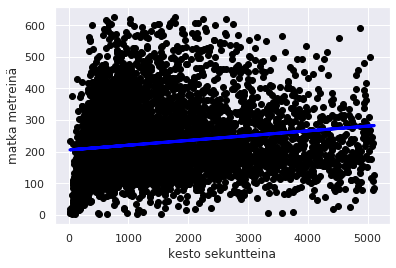

In [90]:
y_pred = model.predict(kesto)

plt.scatter(kesto, matka,  color='black')
plt.plot(kesto, y_pred, color='blue', linewidth=3)
plt.xlabel('kesto sekuntteina')
plt.ylabel('matka metreinä')

plt.show()

# Clean data linear-regression

coefficient of determination: 0.027154495417163527
intercept: 208.42993921441925
slope: [0.01462139]


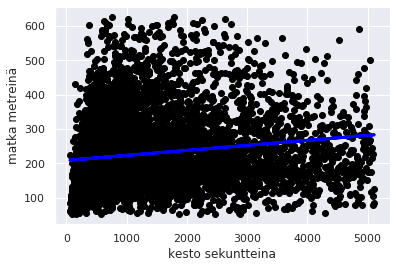

In [128]:
import numpy as np
from sklearn.linear_model import LinearRegression


matka = df_clean.distance.values
kesto = df_clean.kesto.values
kesto = kesto.reshape((-1, 1))

model = LinearRegression()
model.fit(kesto, matka)

r_sq = model.score(kesto,matka)
print('coefficient of determination:', r_sq)

print('intercept:', model.intercept_)
intercept: 5.633333333333329
print('slope:', model.coef_)

y_pred = model.predict(kesto)

plt.scatter(kesto, matka,  color='black')
plt.plot(kesto, y_pred, color='blue', linewidth=3)
plt.xlabel('kesto sekuntteina')
plt.ylabel('matka metreinä')

plt.show()


# Mikä on ennuste kauppareitin pituudelle, kun siihen kului aikaa 5 min 30 s?

In [130]:
y_pred = model.predict([[660]])
print(y_pred)

[218.08005636]


# Mikä on ennuste kauppareissun kestolle pe klo 16-17, kun kauppareissun pituus on keskipitkä?

In [119]:
bins = [60,300, 900, 1500 , 3600, 7200]
#labels = ['lyhyt', 'normaali', 'pitkä', 'tosi pitkä']
labels = [1, 2, 3, 4, 5]
df_clean['binned'] = pd.cut(df_clean['kesto'], bins, labels=labels)
df_clean

,ajokerta,node_id,kesto,dayofweek,current_hour,distance,binned
1,3,1,1121.998,3,9,219.936854,3
2,4,1,769.999,3,10,349.979207,2
3,5,1,265.000,3,12,207.363103,1
4,7,1,660.002,4,12,367.454784,2
5,8,1,877.001,4,12,511.475758,2
...,...,...,...,...,...,...,...
7273,8948,31,645.998,4,10,156.599509,2
7274,8950,31,1239.000,5,5,579.244362,3
7275,8954,31,2287.001,0,7,234.295562,4
7276,8955,31,3745.999,0,9,156.742423,5


# Fit ja pottumage

In [126]:

model = LinearRegression()
model.fit(df_clean[['dayofweek', 'current_hour', 'binned']].values, df_clean.kesto)

y_pred = model.predict([[4,0,5]])

print(y_pred)

[3402.44945397]


# Mikä on ennuste kauppareissun kestolle ke klo 17-18, kun ostetaan tuotteet; einekset, lihatuotteet, maitotuotteet, virvokkeet, makeiset?

In [93]:
df_clean.kesto.mean()

1273.888275770925